## Machine Learning Model Comparison for Multivariate Ground Surface Motion Analysis

*This notebook employs and compares the performance of various Machine Learning models to predict Ground Surface Motion. Models explored in this notebook include GradientBoostingRegression (GBR), RandomForest (RF), Decision Tree Regressor (DT), Support Vector Regressor (SVR), K Nearest Neighbours (KNN), Back Propogating Neural Network (BPNN), Linear Regression (LR), and XGBoost (XGB). K-Fold Cross Validation is utilized to provide and robust and accurate evalution of the models across declared datasets*


**Author**: Utsav Dutta <br>
**Contact**: dutta.utsav14@gmail.com <br> 
**Affiliation**: B.S. in Computer Systems Engineering, Department of Engineering, University of Alaska Anchorage <br>
**Date**: April 2025 <br>
**Last Updated**: April 2025

### 0. User Config

In [48]:
# EXPORTING
export_results_to_excel_file = True
file_name = "results.xlsx"

# K FOLD
k_fold = 5

### 1. Packages

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

### 2. Data Preparation

*We assign the coloumns of our CSV into a pandas dataframe. Please note, **better model performance may require custom data augmentation***

In [51]:
df = pd.read_csv("StationsBeta5.csv")
df = df.dropna()

features = ["mag", "longitude", "latitude", "depth (km)", "distance (km)", "vs30"]
X = df[features]

df["log_pga"] = np.log10(df["pga (%g)"])
df["log_pgv"] = np.log10(df["pgv (cm/s)"])
Y = df["log_pga"] # Change to ["log_pgv"] for PGV

### 3. K-Fold Cross Validation
*To ensure unbiased model evaluation, we utilize K-Fold Cross Validation. This technique partitions the data set into K equally sized folds, for each iteration, one fold is used as a validation set while the remainder are used for training. This allows us to robustly evaluate and compare the performance of the different ML models, and mitigates the risk of overfitting or data partitioning bias*

In [52]:
def kcross_validate(X, y, model_fn, splits, is_NN=False, epoch_num=50, validation_split_val=0.2, batch_size_val=16):
    kf = KFold(n_splits=splits, shuffle=True, random_state=42)
    
    r2_scores, mae_scores, mse_scores, rmse_scores = [], [], [], []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
        if is_NN:
            model = model_fn(X_train.shape[1]) 
            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            model.fit(X_train, y_train,
                      validation_split=validation_split_val,
                      batch_size=batch_size_val,
                      epochs=epoch_num,
                      verbose=0,
                      callbacks=[early_stop])
            y_pred = model.predict(X_test).flatten()
        else:
            model = model_fn()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
    
        
        r2_scores.append(r2_score(y_test, y_pred))
        mae_scores.append(mean_absolute_error(y_test, y_pred))

        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
        rmse_scores.append(np.sqrt(mse))
    

    return {
        "R": [np.mean(np.sqrt(r2_scores)), np.std(np.sqrt(r2_scores))],
        "R^2": [np.mean(r2_scores), np.std(r2_scores)],
        "MAE": [np.mean(mae_scores), np.std(mae_scores)],
        "MSE": [np.mean(mse_scores), np.std(mse_scores)], 
        "RMSE": [np.mean(rmse_scores), np.std(rmse_scores)], 
    }

### 4. Model Implementation

*Here we implement GradientBoostingRegression (GBR), RandomForest (RF), Decision Tree Regressor (DT), Support Vector Regressor (SVR), K Nearest Neighbours (KNN),  Linear Regression (LR), and XGBoost (XGB). **Hyperparameters may require further tweaking to provide optimal performance metrics for a given dataset.***

In [53]:
model_results = {}

models = {
    "GradientBoosting": lambda: GradientBoostingRegressor(
        n_estimators=90, 
        learning_rate=0.05, 
        max_depth=2, 
        random_state=43
    ), 
    "RandomForest": lambda: RandomForestRegressor(
        n_estimators=100, 
        criterion='squared_error', 
        max_depth=7, 
        random_state=0
    ),
    "DecisionTree": lambda: DecisionTreeRegressor(
        criterion='squared_error', 
        max_depth=3, 
        random_state=0
    ),
    "SVR": lambda: SVR(
        kernel='rbf', 
        C=5, 
        epsilon=0.1, 
        gamma="scale"
    ),
    "KNN": lambda: KNeighborsRegressor(
        n_neighbors=99
    ),
    "XGBoost": lambda: xgb.XGBRegressor(
        objective="reg:squarederror",  
        eval_metric="rmse",
        max_depth=1,                  
        n_estimators=47,              
        random_state=0,         
        learning_rate=0.73314
    ),
    "LinReg": lambda: LinearRegression(),
}

for name, model in models.items():
    print(f"Evaluating {name}...")
    model_results[name] = kcross_validate(X, Y, model, splits=k_fold, is_NN=False)
print("\nAll Evaluations Complete!")

Evaluating GradientBoosting...
Evaluating RandomForest...
Evaluating DecisionTree...
Evaluating SVR...
Evaluating KNN...
Evaluating XGBoost...
Evaluating LinReg...

All Evaluations Complete!


### 5. Model Results

#### 5.1 Cross Validation Results and Excel

In [54]:
print("\nCross-Validation Results (mean ± std):")
for name, metrics in model_results.items():
    print(f"\n{name}")
    for metric, (mean, std) in metrics.items():
        print(f"  {metric}: {mean:.3f} ± {std:.3f}")


def export_model_results_to_excel(model_results, file_name):
    rows = []
    for model_name, metrics in model_results.items():
        row = {"Model": model_name}
        for metric, (mean, std) in metrics.items():
            row[f"{metric} (mean)"] = round(mean, 4)
            row[f"{metric} (std)"] = round(std, 4)
        rows.append(row)

    df = pd.DataFrame(rows)

    metric_names = next(iter(model_results.values())).keys()
    ordered_cols = ["Model"]
    for metric in metric_names:
        ordered_cols.extend([f"{metric} (mean)", f"{metric} (std)"])
    df = df[ordered_cols]

    with pd.ExcelWriter(file_name, engine='xlsxwriter') as writer:
        df.to_excel(writer, index=False, sheet_name="Results")

        workbook  = writer.book
        worksheet = writer.sheets["Results"]

        header_format = workbook.add_format({
            'bold': True,
            'text_wrap': True,
            'valign': 'top',
            'align': 'center',
            'border': 1
        })

        for col_num, value in enumerate(df.columns):
            worksheet.write(0, col_num, value, header_format)
            worksheet.set_column(col_num, col_num, 18)  # Auto column width

    print(f"\nExported to {file_name}")

if export_model_results_to_excel: export_model_results_to_excel(model_results, file_name)



Cross-Validation Results (mean ± std):

GradientBoosting
  R: 0.861 ± 0.007
  R^2: 0.741 ± 0.013
  MAE: 0.296 ± 0.004
  MSE: 0.139 ± 0.005
  RMSE: 0.373 ± 0.006

RandomForest
  R: 0.887 ± 0.005
  R^2: 0.787 ± 0.009
  MAE: 0.266 ± 0.003
  MSE: 0.115 ± 0.003
  RMSE: 0.338 ± 0.004

DecisionTree
  R: 0.767 ± 0.011
  R^2: 0.588 ± 0.017
  MAE: 0.368 ± 0.005
  MSE: 0.222 ± 0.005
  RMSE: 0.471 ± 0.006

SVR
  R: 0.894 ± 0.003
  R^2: 0.800 ± 0.006
  MAE: 0.256 ± 0.002
  MSE: 0.108 ± 0.001
  RMSE: 0.328 ± 0.002

KNN
  R: 0.848 ± 0.004
  R^2: 0.719 ± 0.007
  MAE: 0.304 ± 0.005
  MSE: 0.151 ± 0.005
  RMSE: 0.389 ± 0.007

XGBoost
  R: 0.863 ± 0.009
  R^2: 0.745 ± 0.015
  MAE: 0.296 ± 0.003
  MSE: 0.137 ± 0.005
  RMSE: 0.371 ± 0.007

LinReg
  R: 0.851 ± 0.009
  R^2: 0.724 ± 0.016
  MAE: 0.307 ± 0.003
  MSE: 0.148 ± 0.004
  RMSE: 0.385 ± 0.006

Exported to results.xlsx


#### 5.2 Plots

##### 5.2.1 Performance Metrics Bar Graph

In [55]:
# PLOT CONFIG
metrics = ["R", "R^2", "RMSE", "MSE", "MAE"]  # ["R", "R^2", "RMSE", "MSE", "MAE"] is all
pastel_colors = ["#FD8A8A", "#FFB347", "#77DD77", "#9EA1D4", "#B39EB5"] # Colors plotted sequentially by metric index

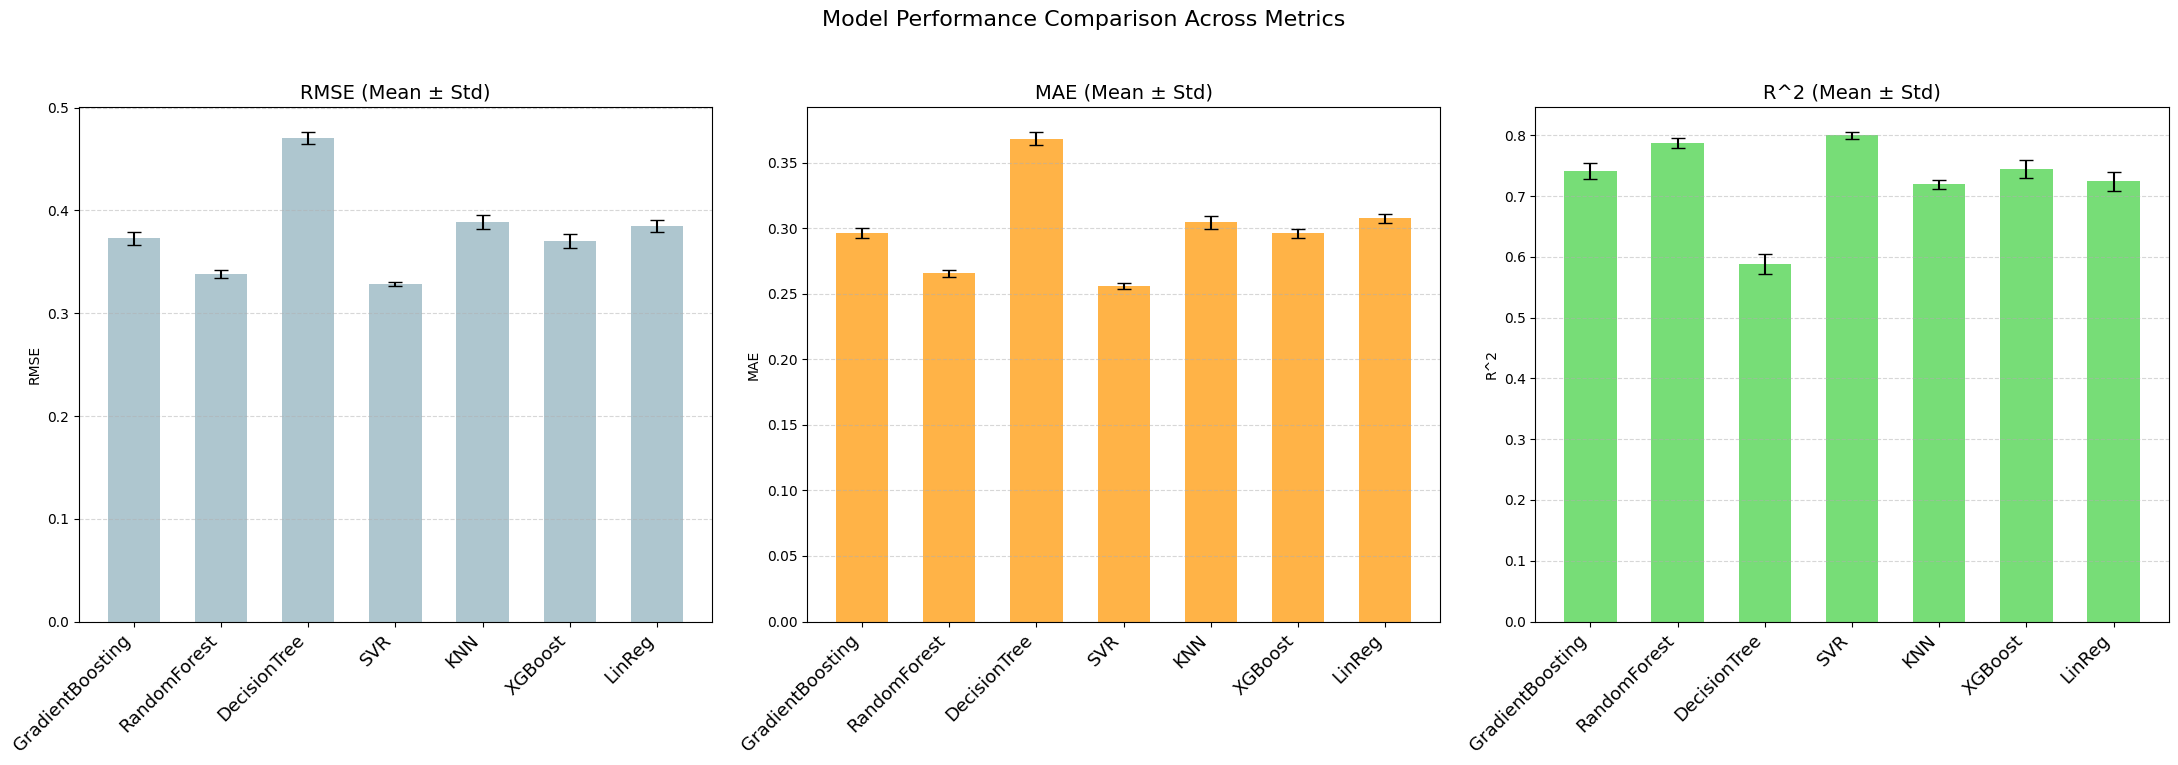

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_model_results(model_results, metric_list, pastel_colors):
    models = list(model_results.keys())
    n_models = len(models)

    fig, axs = plt.subplots(1, len(metric_list), figsize=(22, 8)) 
    x = np.arange(n_models)
    width = 0.6

    for idx, metric in enumerate(metric_list):
        ax = axs[idx]
        means = [model_results[model][metric][0] for model in models]
        stds = [model_results[model][metric][1] for model in models]

        bars = ax.bar(x, means, width, yerr=stds, capsize=5, color=pastel_colors[idx])

        ax.set_title(f"{metric} (Mean ± Std)", fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=13)
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)
        ax.set_ylabel(metric)

    fig.suptitle("Model Performance Comparison Across Metrics", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # So the title doesn't overlap
    plt.show()

# Example usage
metric_list = ['RMSE', 'MAE', 'R^2']
pastel_colors2 = ['#AEC6CF', '#FFB347', '#77DD77']  # Customize if you want different soft colors

plot_all_model_results(model_results, metric_list, pastel_colors2)


['R', 'R^2', 'RMSE', 'MSE', 'MAE']


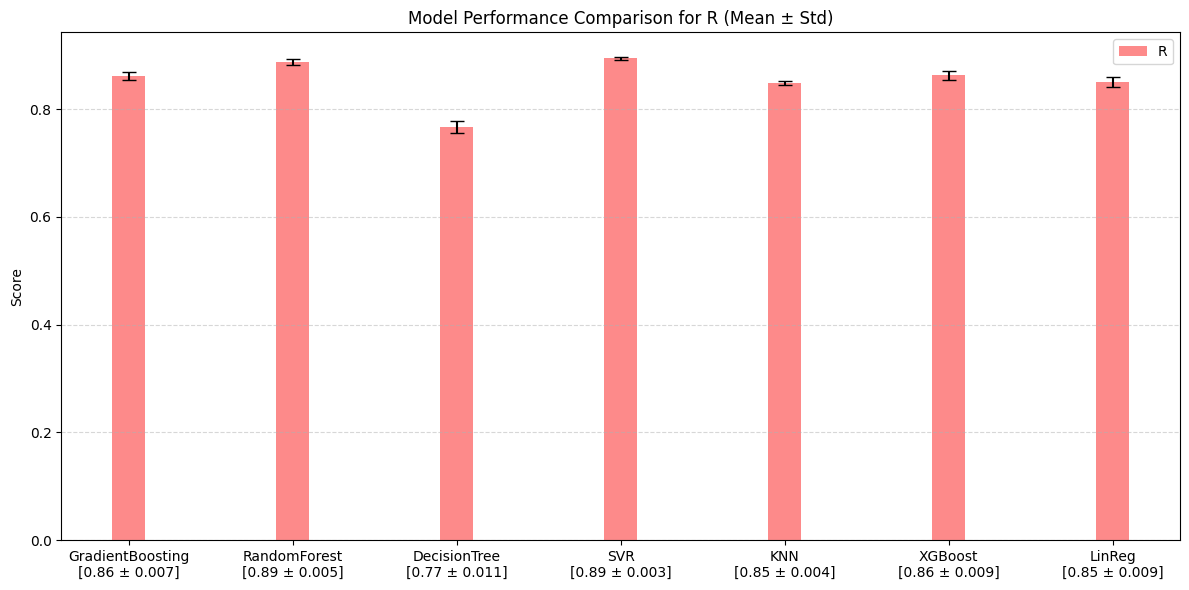

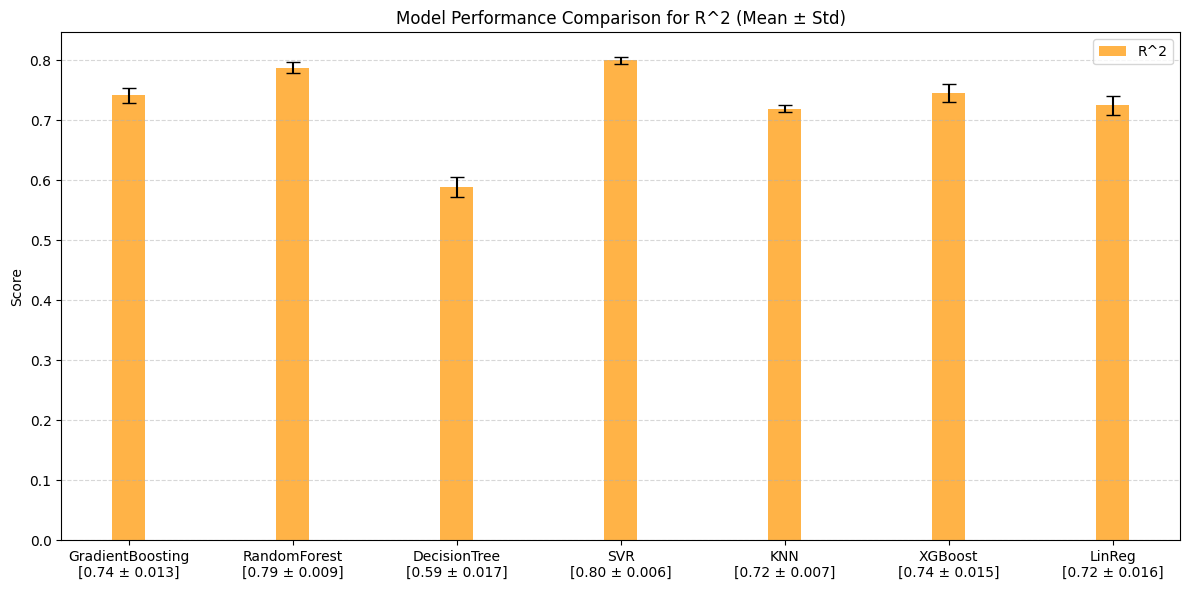

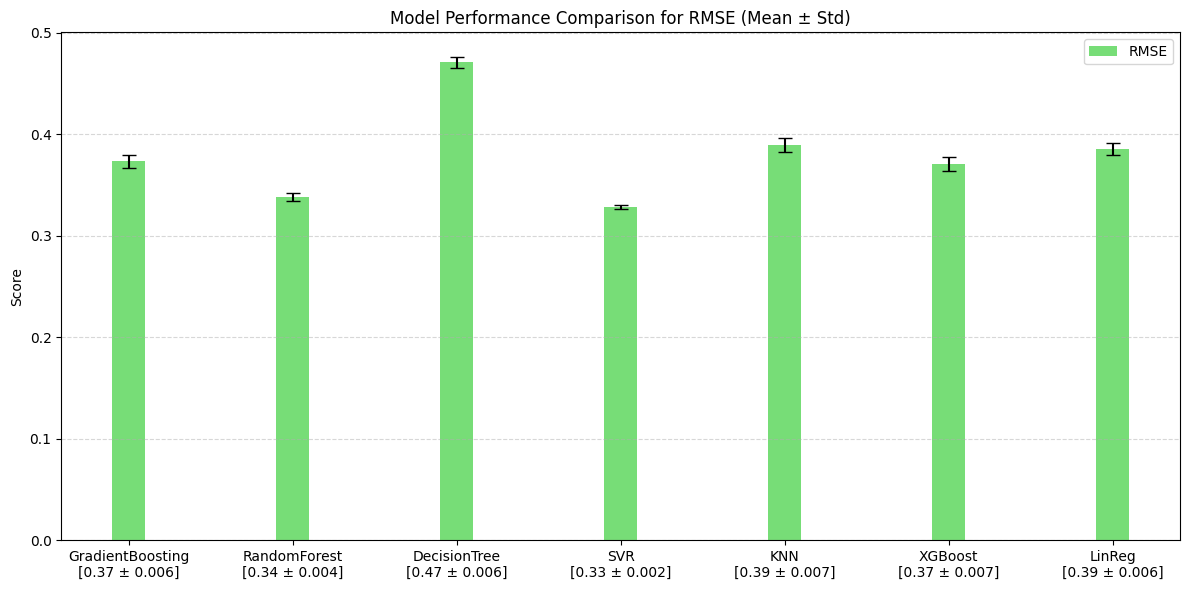

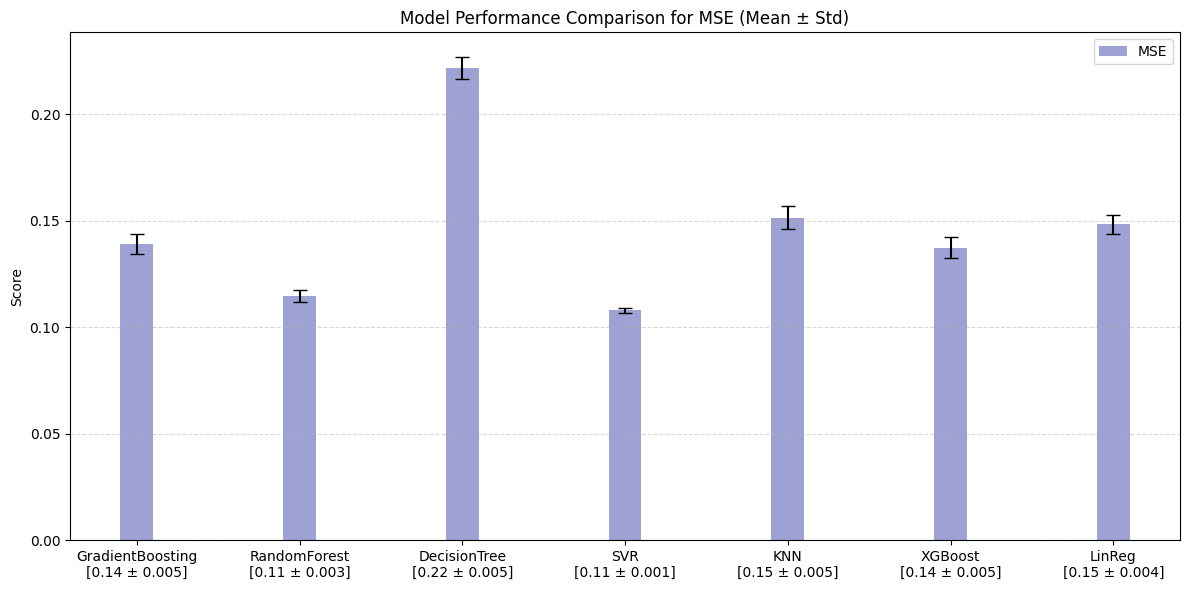

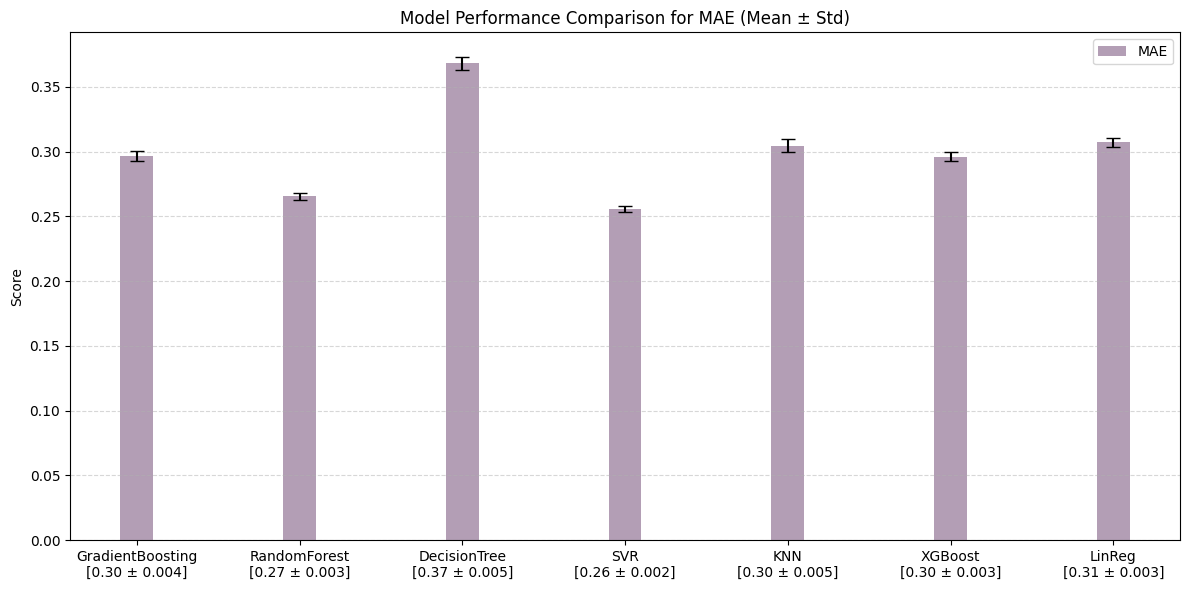

In [57]:
def plot_model_results_bargraph(model_results, metric_list, color_name):
    metrics = metric_list
    models = list(model_results.keys())
    n_metrics = len(metrics)
    n_models = len(models)

    x = np.arange(n_models)
    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))
    new_xticklabels = []

    for i, metric in enumerate(metrics):
        means = [model_results[model][metric][0] for model in models]
        stds  = [model_results[model][metric][1] for model in models]
        offset = (i - n_metrics / 2) * width + width / 2
        ax.bar(x + offset, means, width, yerr=stds, capsize=5, label=metric, color=color_name)

        if i == 0:
            for j, model in enumerate(models):
                labels = []
                for m in metrics:
                    mean = model_results[model][m][0]
                    std = model_results[model][m][1]
                    labels.append(f"[{mean:.2f} ± {std:.3f}]")
                new_xticklabels.append(f"{model}\n" + "\n".join(labels))
            
    ax.set_xticks(x)
    ax.set_xticklabels(new_xticklabels, rotation=0, ha='center')
    ax.set_ylabel("Score")
    ax.set_title(f"Model Performance Comparison for {metrics[0]} (Mean ± Std)")
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

print(metrics)

for i, j in zip(metrics, pastel_colors[:len(metrics)]):
    plot_model_results_bargraph(model_results, [i], j)

##### 5.2.3 Feature Correlation

*The following graph is a feature correlation using Pearson correlation coefficient between every pair of numeric values in the dataset. A p value of +1 indicates a perfect positive linear relationship, while a p value of -1 indicates a perfect negative linear relationship*

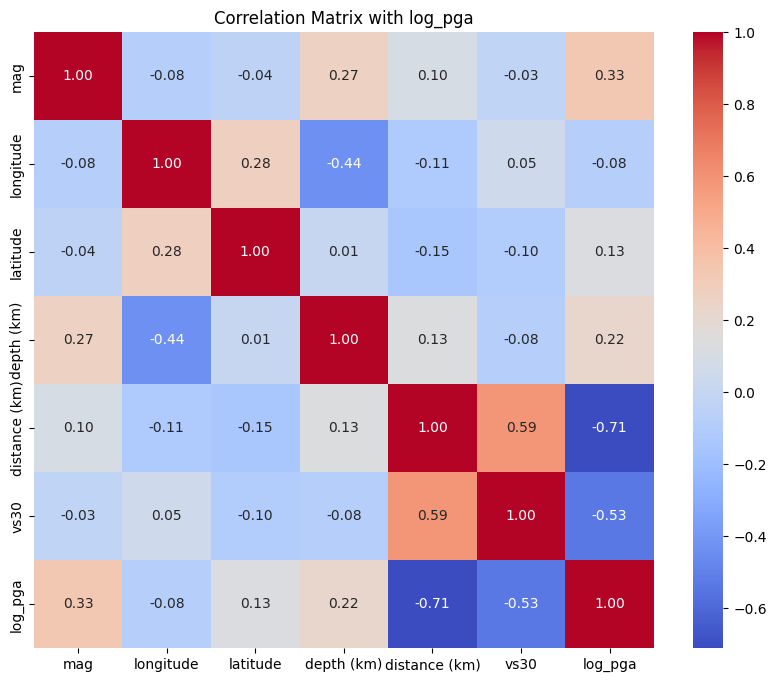

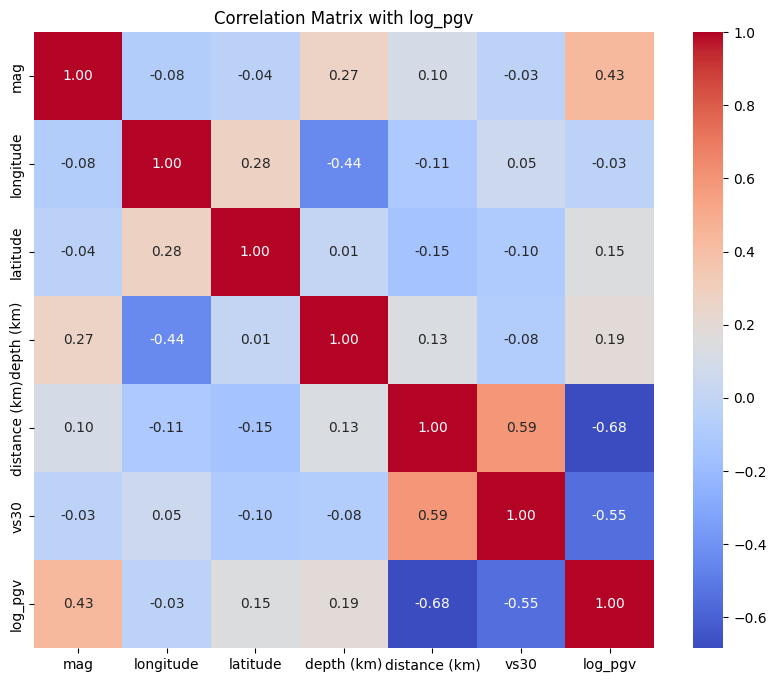

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("StationsBeta5.csv")
df = df.dropna()
features = ["mag", "longitude", "latitude", "depth (km)", "distance (km)", "vs30"]
X = df[features]

df["log_pga"] = np.log10(df["pga (%g)"])
df["log_pgv"] = np.log10(df["pgv (cm/s)"])

X_pga = X.copy()
X_pga["log_pga"] = df["log_pga"]

X_pgv = X.copy()
X_pgv["log_pgv"] = df["log_pgv"]

plt.figure(figsize=(10, 8))
sns.heatmap(X_pga.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix with log_pga")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(X_pgv.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix with log_pgv")
plt.show()

### 6. Application

Train R²  : 0.824
Test  R²  : 0.804
Test RMSE : 0.333


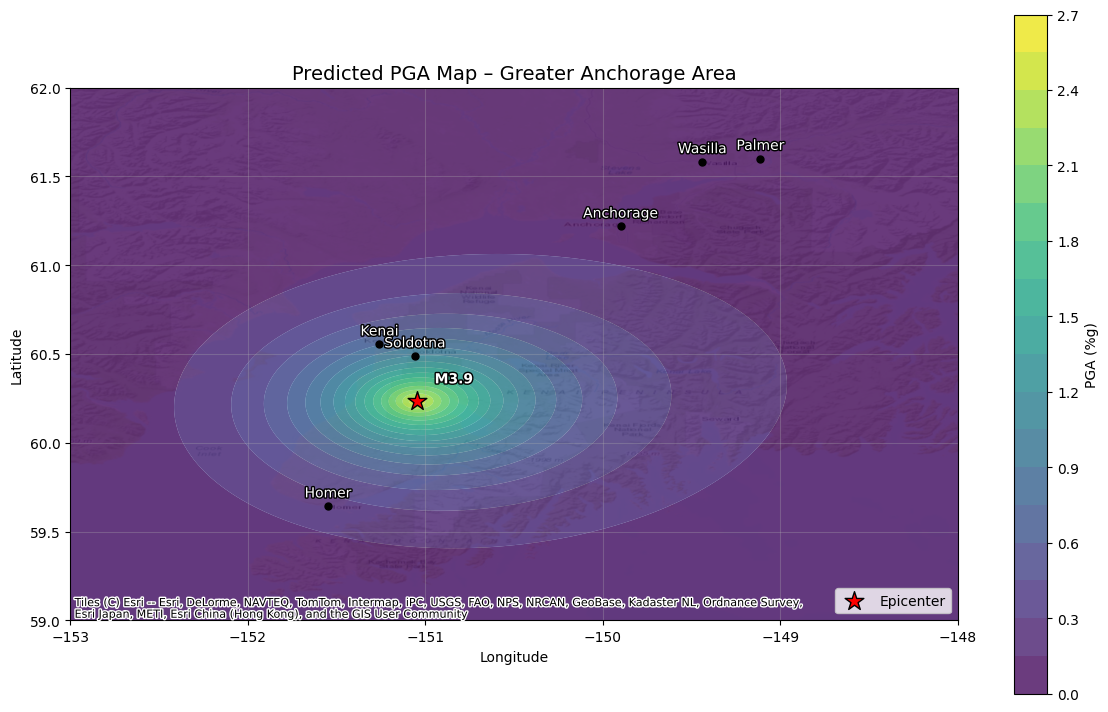

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import contextily as ctx
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as pe

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_csv("StationsBeta5.csv").dropna()

feature_cols = ["mag", "longitude", "latitude",
                "depth (km)", "distance (km)", "vs30"]

X = df[feature_cols].copy()
df["log_pga"] = np.log10(df["pga (%g)"])
y = df["log_pga"]

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=43)


svr_pipe = make_pipeline(
        StandardScaler(),
        SVR(kernel="rbf", C=5, epsilon=0.1, gamma="scale")
)

svr_pipe.fit(X_train, y_train)

print(f"Train R²  : {svr_pipe.score(X_train, y_train):.3f}")
print(f"Test  R²  : {svr_pipe.score(X_test,  y_test ):.3f}")
print(f"Test RMSE : {np.sqrt(mean_squared_error(y_test, svr_pipe.predict(X_test))):.3f}")


min_latitude  = 59
max_latitude  = 62
min_longitude = -153
max_longitude = -148
vs30_const    = 400        # assumed constant for scenario

quake_lat  = 60.2348
quake_lon  = -151.0476
quake_depth = 64.7
quake_mag   = 3.9

lat_vals = np.linspace(min_latitude,  max_latitude, 200)
lon_vals = np.linspace(min_longitude, max_longitude, 200)
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)

flat_coords = np.column_stack([lon_grid.ravel(), lat_grid.ravel()])
distances_km = np.array([
    geodesic((lat, lon), (quake_lat, quake_lon)).km
    for lon, lat in flat_coords
])

df_pred = pd.DataFrame({
    "mag": quake_mag,
    "longitude": flat_coords[:, 0],
    "latitude":  flat_coords[:, 1],
    "depth (km)": quake_depth,
    "distance (km)": distances_km,
    "vs30": vs30_const
})


log_pga_pred = svr_pipe.predict(df_pred)
pga_pred     = 10 ** log_pga_pred            # back-transform to % g
pga_grid     = pga_pred.reshape(lat_grid.shape)

fig, ax = plt.subplots(figsize=(12, 10))

colors = plt.cm.viridis(np.linspace(0, 1, 256))
colors[:, 3] = 0.7                  # constant alpha
cmap_alpha = LinearSegmentedColormap.from_list("viridis_a", colors)

cont = ax.contourf(lon_grid, lat_grid, pga_grid,
                   levels=20, cmap=cmap_alpha, alpha=0.8, antialiased=True)

cbar = plt.colorbar(cont, label="PGA (%g)", shrink=0.7)
cbar.ax.tick_params(labelsize=10)


ax.scatter(quake_lon, quake_lat, marker="*", s=200,
           color="red", edgecolor="black", zorder=10, label="Epicenter")
ax.text(quake_lon+0.1, quake_lat+0.1, f"M{quake_mag}",
        color="white", fontweight="bold", zorder=11,
        path_effects=[pe.withStroke(linewidth=2, foreground="black")])

ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.Esri.WorldTopoMap)

cities = {
    "Anchorage": (61.2181, -149.9003),
    "Wasilla":   (61.5814, -149.4394),
    "Palmer":    (61.5997, -149.1127),
    "Kenai":     (60.5544, -151.2583),
    "Soldotna":  (60.4878, -151.0583),
    "Homer":     (59.6425, -151.5483)
}
for name, (lat, lon) in cities.items():
    if (min_longitude <= lon <= max_longitude and
        min_latitude  <= lat <= max_latitude):
        ax.plot(lon, lat, "ko", markersize=5)
        ax.text(lon, lat+0.05, name, ha="center", color="white",
                path_effects=[pe.withStroke(linewidth=2, foreground="black")])

ax.set_title("Predicted PGA Map – Greater Anchorage Area", fontsize=14)
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
ax.legend(loc="lower right", fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("anchorage_pga_map.png", dpi=300, bbox_inches="tight")
plt.show()
